In [1]:
import io
import time

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image, ImageFilter

In [2]:
classes = ['adult', 'main', 'text']
num_classes = len(classes)

In [3]:
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
weights = torch.load('dump/201903130303/model-9.bin', map_location=torch.device('cpu'))
model.load_state_dict(weights)
_ = model.eval()

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:7')
    model.to(device)
else:
    device = torch.device('cpu')
# next(model.parameters()).is_cuda

In [5]:
print(device)

cpu


In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
urls = [
    'https://mimgnews.pstatic.net/image/117/2018/12/05/201812050856659677_1_20181205090234996.jpg',    # adult
    'https://ssl.pstatic.net/mimgnews/image/016/2018/12/14/201812141334180069586_20181214133550_01_20181214134308300.jpg',    # adult
    'https://mimgnews.pstatic.net/image/119/2017/03/12/0002172148_001_20170312142812536.jpg',    # adult
    'https://imgnews.pstatic.net/image/079/2018/12/21/0003178146_001_20181221113108900.jpg',    # text
    'https://imgnews.pstatic.net/image/030/2018/12/21/0002770000_001_20181221135021015.jpg',    # logo
    'https://imgnews.pstatic.net/image/001/2019/03/11/PCM20190213000367990_P2_20190311234036509.jpg',    # main
    'https://obs.line-scdn.net/0hXZVK8EPHB3VrMi0dDgB4IlNvARoSXRRlFUoQDT1iKiI1WRJEDDYwejBAHx1GChUjU1RPGgszUUAVCxcnUw',    # adult
]

In [8]:
def predict(model, transform, url):
    start = time.time()
    res = requests.get(url, stream=True)
    end = time.time()
    print('download: {}'.format(end - start))
    
    start = end
    img = Image.open(io.BytesIO(res.content))
    img = img.convert('RGB')
    inputs = transform(img)
    end = time.time()
    print('transform: {}'.format(end - start))
    
    start = end
    outputs = model(inputs.unsqueeze(0).to(device))
    end = time.time()
    print('forward: {}'.format(end - start))
    
    start = end
    logits = torch.softmax(outputs, 1)
    prob, idx = torch.max(logits, 1)
    name = classes[idx]
    end = time.time()
    print('predict: {}'.format(end - start))
    
    plt.title('{}: {:.4f}'.format(name, float(prob)))
    plt.imshow(img)

download: 0.0337224006652832
transform: 0.03576779365539551
forward: 4.628950595855713
predict: 0.0017514228820800781


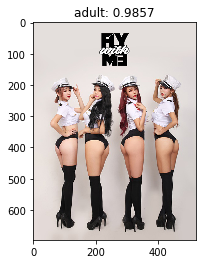

In [9]:
predict(model, transform, urls[0])

download: 0.019020557403564453
transform: 0.01324319839477539
forward: 4.054183483123779
predict: 0.0010654926300048828


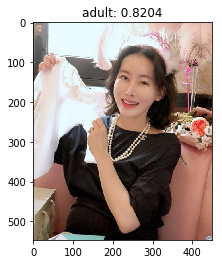

In [10]:
predict(model, transform, urls[1])

download: 0.03486156463623047
transform: 0.03263688087463379
forward: 3.715074300765991
predict: 0.0011758804321289062


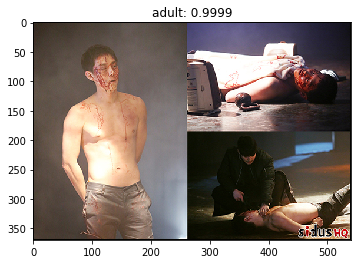

In [11]:
predict(model, transform, urls[2])

download: 0.03569984436035156
transform: 0.01640033721923828
forward: 3.890814781188965
predict: 0.0011572837829589844


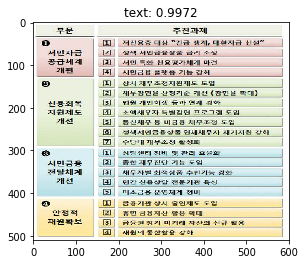

In [12]:
predict(model, transform, urls[3])

download: 0.04017281532287598
transform: 0.008162736892700195
forward: 3.9084813594818115
predict: 0.0012426376342773438


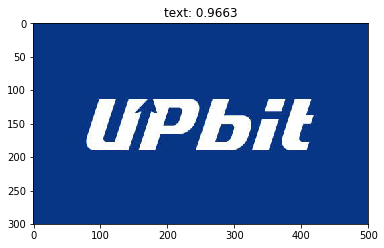

In [13]:
predict(model, transform, urls[4])

download: 0.03107309341430664
transform: 0.00933837890625
forward: 4.3933422565460205
predict: 0.0005602836608886719


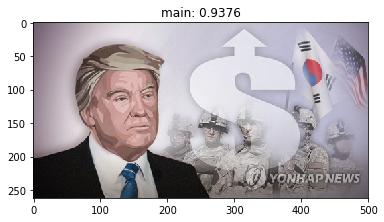

In [14]:
predict(model, transform, urls[5])

download: 0.02330803871154785
transform: 0.009156227111816406
forward: 4.384596109390259
predict: 0.0008180141448974609


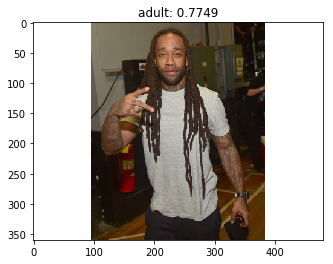

In [15]:
predict(model, transform, urls[6])

In [16]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

0
0


In [17]:
torch.cuda.empty_cache()

# Misc

In [18]:
# torch.max behavior
print(torch.max(torch.randn(2, 3)))
print(torch.max(torch.randn(2, 3), 1))

tensor(0.1899)
(tensor([0.3921, 1.0602]), tensor([0, 2]))


In [19]:
# transform 된 image를 다시 되돌림
def im_convert(tensor):
  img = tensor.clone().detach().numpy()
  img = img.transpose(1, 2, 0)
  img = img * np.array([0.485, 0.456, 0.406] + np.array([0.229, 0.224, 0.225]))
  img = img.clip(0, 1)
  return img

In [20]:
# plt.imshow(im_convert(transform(img)))